In [1]:
# import libraries from pyspark 
from pyspark import SparkConf, SparkContext

# set values for spark configuration
conf = SparkConf().setMaster("local").setAppName("tutorial")

# get (if already running) or create a spark context
sc = SparkContext.getOrCreate(conf=conf)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/02/24 23:59:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/02/24 23:59:09 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [2]:
# check (try) if spark context variable (sc) exists and print information about the spark context
try:
    sc
except NameError:
    print("please create SparkContext first (run cell above)")
else:
    configurations = sc.getConf().getAll()
    for item in configurations: print(item)

('spark.master', 'local')
('spark.app.submitTime', '1740430748722')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false')
('spark.driver.host', '192.168.2.118')


In [3]:
sc

<SparkContext master=local appName=tutorial>

# creating rdds:

### the first way to create an rdd

### is to parallelize an python object

### meaning converting it to a distributed dataset that can be operated in parallel

In [4]:
# create a list of strings
stringList = ["spark is awesome","spark is cool"]

# convert list of strings into a spark rdd
stringRDD = sc.parallelize(stringList)

In [5]:
# output rdd information
stringRDD

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:289

one thing to notice is that you are not able to see the output

because of spark's lazy evaluation untill you call an action on that rdd

In [6]:
# retrieve all the elements of the rdd/dataFrame/dataset (from all nodes)
stringRDD.collect()

['spark is awesome', 'spark is cool']

.collect() is an action 

as it name suggests it collects all the rows from each of the partitions in an rdd 

and brings them over to the driver program

### the second way to create an RDD is 

### to read a dataset from a storage system which can be a 

### local computer file system

### hdfs 

### cassandra

### amazon s3

In [8]:
# read text file into rdd
ratings = sc.textFile("./ratings.dat")

In [9]:
# retrieve all the elements of the rdd/dataFrame/dataset (from all nodes) and output first 5 rows
ratings.collect()[:5]

['1::1193::5::978300760',
 '1::661::3::978302109',
 '1::914::3::978301968',
 '1::3408::4::978300275',
 '1::2355::5::978824291']

In [10]:
# take the first 5 elements of the rdd
ratings.take(5)

['1::1193::5::978300760',
 '1::661::3::978302109',
 '1::914::3::978301968',
 '1::3408::4::978300275',
 '1::2355::5::978824291']

![Screenshot 2025-02-10 at 13.04.12.png](<attachment:Screenshot 2025-02-10 at 13.04.12.png>)
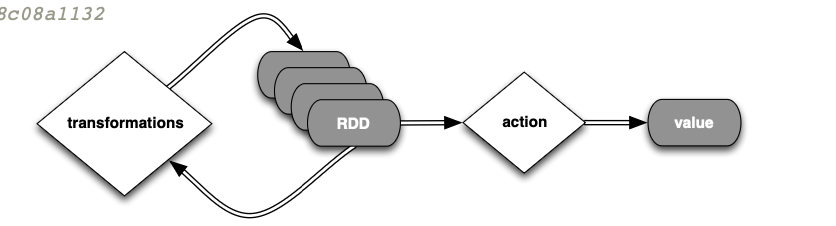

# actions

### get num partitions action:

return the number of partitions in rdd

In [11]:
# create rdd 'x' with two partitions
x = sc.parallelize([1,2,3],2)

numPartitions = x.getNumPartitions()

# glom() flattens elements on the same partition
print(x.collect())
print(x.glom().collect())
print(numPartitions)

[1, 2, 3]
[[1], [2, 3]]
2


## collect action:

return all items in the rdd to the driver in a single list

In [12]:
# create rdd 'x' with two partitions
x = sc.parallelize([1,2,3],2)

print(x.glom().collect())
print(x.collect())

[[1], [2, 3]]
[1, 2, 3]


## count action:

return the number of elements in this rdd

In [13]:
# create new rdd 'numberRDD' with two partitions
numberRDD = sc.parallelize([1,2,3,4,5,6,7,8,9,10],2)

# the action count returns the number of element in the dataset - independent of the number of partitions 
numberRDD.count()

10

## first action:

return the first element in this rdd

In [14]:
# create new rdd 'numberRDD' with two partitions
numberRDD = sc.parallelize([1,2,3,4,5,6,7,8,9,10],2)

# return the first element - the order of the elements within the rdd is not effected by the partitioning
numberRDD.first()

1

## take action:

take the first num elements of the rdd

In [15]:
# create new rdd 'numberRDD' with two partitions
numberRDD = sc.parallelize([1,2,3,4,5,6,7,8,9,10],2)

# return the first four element - the order of the elements within the rdd is not effected by the partitioning
numberRDD.take(4)

[1, 2, 3, 4]

## reduce action:

aggregate all the elements of the rdd 

by applying a user function pairwise to elements and partial results

and returns a result to the driver

In [16]:
# create new rdd 'x'
x = sc.parallelize([1,2,3,4])

# apply function pairwise (a,b) to elements and return the sum - return type is integer
y = x.reduce(lambda a,b: a+b)

print(x.collect())
print(y)

[1, 2, 3, 4]
10


## aggregate action:

since rdds are partitioned

the aggregate takes full advantage of it 

by first aggregating elements in each partition 

and then aggregating results of all partition to get the final result

aggregate all the elements of the rdd by:

- applying a user function to combine elements with user-supplied objects

- then combining those user-defined results via a second user function
    
- and finally returning a result to the driver

In [22]:
# the seqOp operator is used to accumulate the results of each partition and stores the running 
# accumulated result to data
seqOp = lambda data, item: (data[0] + [item], data[1] + item)

# The combOp is used to combine the results of all partitions
combOp = lambda d1, d2: (d1[0] + d2[0], d1[1] + d2[1])

# create new rdd 'x'
x = sc.parallelize([1,2,3,4])

# aggregate all elements of the rdd
y = x.aggregate(([], 0), seqOp, combOp)
print(y)

([1, 2, 3, 4], 10)


## max action:

return the maximum item in the rdd

In [17]:
# create new rdd 'x'
x = sc.parallelize([1,2,4,3])

# return the maximum value from the dataset
x.max()

4

# stop the spark session

In [18]:
try:
    sc
except NameError:
    print("spark context does not context exist - nothing to stop")
else:
    sc.stop()